In [29]:
import sys
sys.path.append("..")
import mlflow
import pandas as pd
import tasks.analysis as analysis
import config.config as config

mlflow.set_tracking_uri('../mlruns')

In [30]:
#read analysis configuration
conf = None
conf = config.read_config('../config/gemini.cfg')

# run dataset drift analysis and generate html report: compare two years 2016 and 2017
conf.html = True
conf.slice = 'year'
conf.data_ref = [2016]
conf.data_eval = [2017]

conf.report_path = '../../'


{'config_file': None, 'extract': False, 'train': False, 'predict': False, 'analyze': False, 'user': 'koshkinam', 'password': 'Masha1978', 'port': 5432, 'host': 'db.gemini-hpc.ca', 'database': 'delirium_v3_0_0', 'w': False, 'r': False, 'input': '/mnt/nfs/project/delirium/data/all_before_2018.csv', 'output_folder': '/mnt/nfs/project/delirium/data', 'output_full_path': None, 'features': ['hospital_id', 'sex', 'age', 'mort_hosp', 'readmission_7', 'readmission_28', 'palliative', 'los_er', 'icd10_A00_B99', 'icd10_C00_D49', 'icd10_D50_D89', 'icd10_E00_E89', 'icd10_F01_F99', 'icd10_G00_G99', 'icd10_H00_H59', 'icd10_H60_H95', 'icd10_I00_I99', 'icd10_J00_J99', 'icd10_K00_K95', 'icd10_L00_L99', 'icd10_M00_M99', 'icd10_N00_N99', 'icd10_O00_O99', 'icd10_Q00_Q99', 'icd10_R00_R99', 'icd10_S00_T88', 'icd10_U07_U08', 'icd10_Z00_Z99', 'icd10_nan'], 'target': 'los', 'pop_size': 10000, 'filter_year': None, 'filter_date_from': '', 'filter_date_to': '', 'split_column': 'year', 'test_split': '2018', 'val_spl

In [5]:
response = analysis.main(conf)
print(response)

../../dataset_report_2021-Nov-30_09-48-35.html


In [6]:
# Compare data from two hospitals (St Michael's as reference, Mount Sinai as evaluated)
conf.slice = 'hospital_id'
conf.data_ref = [3]
conf.data_eval = [7]
response = analysis.main(conf)
print(response)

../../dataset_report_2021-Nov-30_09-51-55.html


In [4]:
# run analysis and generate html report (this time model performance comparison)
# looks at the prediction of the model trained on all data before 2018. Compares 2017(val) and 2018 (test).
conf.type = 'performance'
conf.reference= '../../gemini_val_result.csv' 
conf.test = '../../gemini_test_result.csv'
name = analysis.main(conf)
print(name)

../../performance_report_2021-Nov-30_13-46-44.html


In [31]:
#MLFlow history for analysis
# Display dataset drift analysis runs

import os
import json
import mlflow
import pandas as pd


def get_dataset_metrics_list(data):
     if ('metrics' in data.keys()) and data['metrics']:
        metrics = data['metrics']
        #timestamp = data['params']['timestamp']
        drift = 'No' if metrics['dataset_drift']==0 else 'Yes'
        return [drift, metrics['n_features'], metrics['n_drifted_features']]
     else:
        return ['-', '-', '-']

# List all existing experiments
all_experiments = mlflow.list_experiments()
exp_data = []
for exp in all_experiments:
    row = [exp.name, exp.artifact_location, exp.lifecycle_stage]
    exp_data.append(row)
exp_frame = pd.DataFrame(exp_data, columns = ['Name', 'Artifacts', 'Status'])
#print(exp_frame)
    
exp = mlflow.get_experiment_by_name('DatasetAnalysis')
runs = mlflow.list_run_infos(exp.experiment_id, max_results=5)
table = []
for r in runs:
    exp_run = mlflow.get_run(r.run_id).to_dictionary()
    path = exp_run['info']['artifact_uri'][6:]
    config_file = os.path.join(path, 'config.json')
    if not os.path.isfile(config_file):
        continue
    with open(config_file) as f:
        data = json.load(f)
        row = [data['input'], data['slice'], data['data_ref'], data['data_eval']]
        row = row + get_dataset_metrics_list(exp_run['data'])
        table.append(row)
frame = pd.DataFrame(table, columns=['Input', 'Slice', 'Ref Slice', 'Eval Slice', 'Drift', 'Feat', 'Drift_Feat'])
print('------------------- Dataset Analysis ----------------------')
print(frame)

------------------- Dataset Analysis ----------------------
                                               Input        Slice Ref Slice  \
0  /mnt/nfs/project/delirium/data/all_before_2018...  hospital_id       [3]   
1  /mnt/nfs/project/delirium/data/all_before_2018...         year    [2016]   
2  /mnt/nfs/project/delirium/data/all_before_2018...         year    [2017]   
3  /mnt/nfs/project/delirium/data/all_before_2018...         year    [2017]   
4  /mnt/nfs/project/delirium/data/all_before_2018...         year    [2017]   

  Eval Slice Drift  Feat  Drift_Feat  
0        [7]   Yes  28.0        23.0  
1     [2017]    No  28.0         7.0  
2     [2018]    No  28.0        12.0  
3     [2018]    No  28.0        12.0  
4     [2018]    No  28.0        12.0  


In [34]:
# get all the executions folders
executions_folder = '../../executions'
from os import listdir
from os.path import isfile, join
files = [f for f in listdir(executions_folder)]
files.sort()

                  Dataset Analysis Results: number of drifted features  


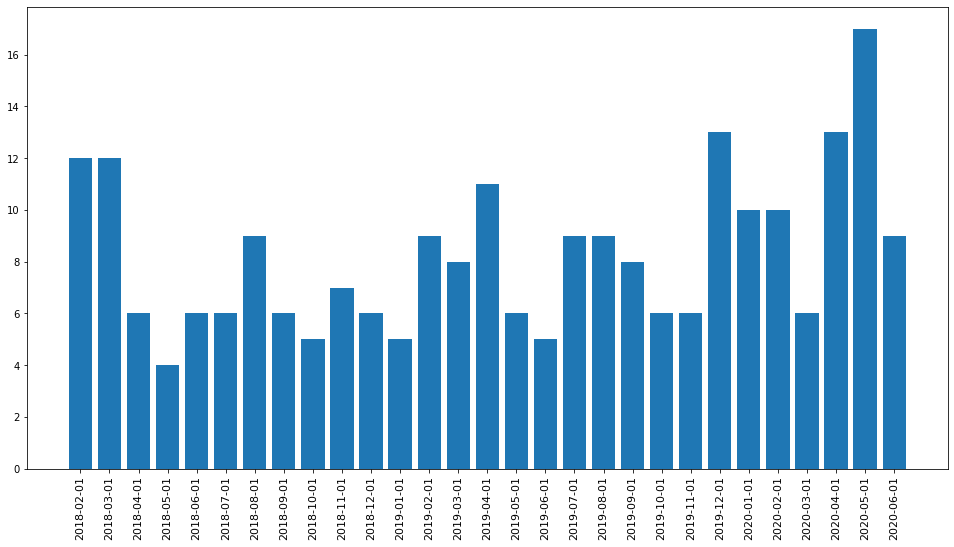

In [48]:
#plot how dataset drift changes over time compared to the reference data

table = []
y = []
for dir_run in files:
    with open(os.path.join(executions_folder, dir_run, 'dataset_report.json')) as f:
        data = json.load(f)
        results = data['data_drift']['data']['metrics']
    
        feat = results['n_features']
        drift = 'Yes' if results['dataset_drift'] else 'No'
        feat_drift = results['n_drifted_features']
        
        y.append(feat_drift)
        row = [dir_run, drift, str(feat_drift)+'/'+str(feat)]
        table.append(row)
    
frame = pd.DataFrame(table, columns=['Period', 'Drift Detected', 'Drifted Features / All Features'])
print('                  Dataset Analysis Results: number of drifted features  ')
#print(frame)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()
fig.set_size_inches(16.5, 8.5)
x = frame['Period'].values
ax.bar(x,y)
ax.xaxis.set_ticks(frame['Period'].values)
ax.set_xticklabels(frame['Period'].values, rotation='vertical', fontsize=11)
plt.show()

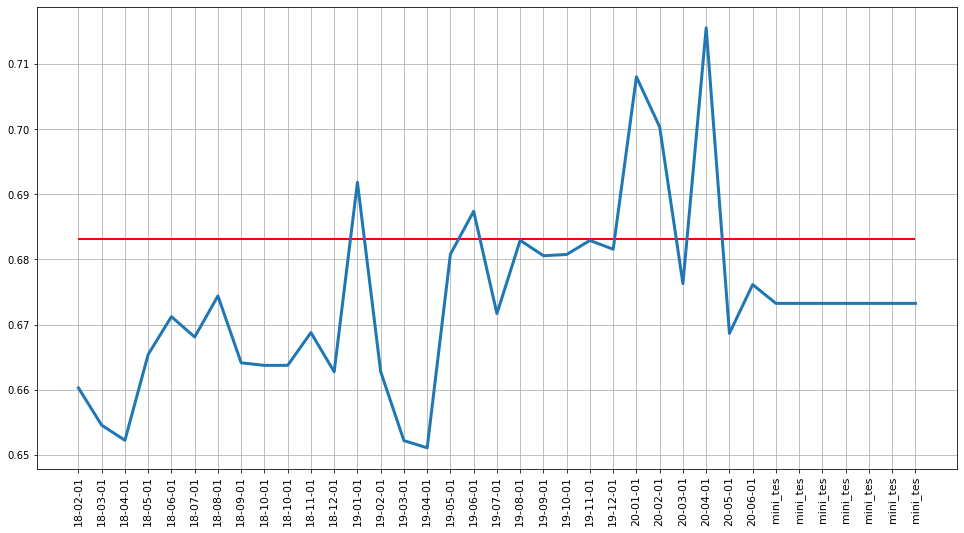

In [8]:
table = []
y = []
for dir_run in files:
    with open(os.path.join(executions_folder, dir_run, 'model_report.json')) as f:
        data = json.load(f)
        results = data['data_drift']['data']['metrics']
    
        feat = results['n_features']
        drift = 'Yes' if results['dataset_drift'] else 'No'
        feat_drift = results['n_drifted_features']
        
        y.append(feat_drift)
        row = [dir_run, drift, str(feat_drift)+'/'+str(feat)]
        table.append(row)
    



import matplotlib.pyplot as plt
import numpy as np

baseline = frame['Ref Acc'].values[0]
frame = frame.sort_values('Eval', axis=0)
fig = plt.figure()
fig.set_size_inches(16.5, 8.5)
ax = plt.axes()
x = list(range(frame.shape[0]))
labels = frame['Eval'].apply(lambda x: x[:8])

y = frame['Eval Acc'].values
plt.plot(x, y, '-', linewidth=3)
ax.hlines(y=baseline, xmin = 0, xmax = max(x), linewidth=2, color='r')

ax.set_xticks(x)
# Set ticks labels for x-axis
ax.set_xticklabels(labels.values, rotation='vertical', fontsize=11)

plt.grid()
plt.show()